In [1]:
import pandas as pd
import io
#Dependencies
import gensim #the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain


#123

df=pd.read_excel('Example for data base.xlsx')



In [2]:
df=df.replace({'Category' : { 'Y' : "Antisemitic", 'W' : "Non-Antisemitic", 'U' : "Anti-Zionist" }})

In [3]:
df = df.replace(r'\n',' ', regex=True) 

post_description=df["A short summary of the content- write briefly in your own words"]


In [4]:
df = df.rename(columns={"חותמת זמן":"Time stamp"})


In [5]:
from datetime import datetime
df['Time stamp'] = pd.to_datetime(df['Time stamp'], errors='coerce') #This function convert the date text into dt.date type


תכנים לפי רשת - גרף עמודות ויזואלי לניטור התכנים לפי רשתות ולפי תקופה

<AxesSubplot:title={'center':'Grouping posts count by social media platform since 2021-07-01'}>

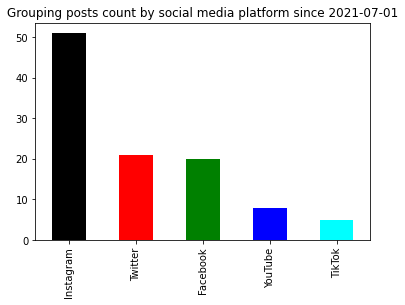

In [6]:
user_input = "2021-07-01"
the_user_target_date = df["Time stamp"]>user_input
new_df = df[the_user_target_date]
new_df["Platform"].value_counts().plot(kind="bar",color=['black', 'red', 'green', 'blue', 'cyan'],title = "Grouping posts count by social media platform since" + " " + user_input)

In [7]:
import matplotlib.pyplot as plt


In [8]:
list = ["Anti-Zionist",
"Antisemitic",
"Non-Antisemitic"]

df = df.loc[df['Category'] .isin(list)]
#This line is keeping rows which have one of the categories


סוג התוכן- גרף עמודות שיפלטר את סוגי התכנים פר הרשת החברתית שמקבלת את הדוח

<AxesSubplot:ylabel='Platform'>

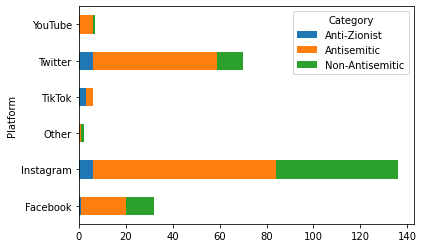

In [9]:

df_group_=df.groupby(['Category', 'Platform'])['Platform'].count().unstack('Category').fillna(0).astype(int)
df_group_.plot(kind='barh', stacked=True,mark_right = True )




In [10]:
df["Removed 1"]=df["Removed 1"].astype("str") 

def convert_to_category_remove_1(symbol):
    for letter in symbol:
        if letter == "X":
            return "Never"
        elif letter == "V":
            return "Second appeal"
        else:
            return "First appeal"

df["Post status"] = df["Removed 1"].apply(convert_to_category_remove_1)

status = df["Post status"]

<AxesSubplot:title={'center':'How many posts removed in 1st / 2nd time, or never?'}, ylabel='Post status'>

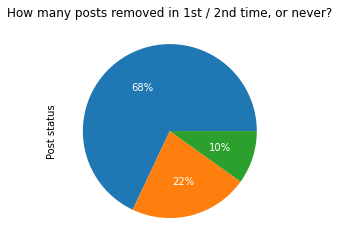

In [11]:
#Cheking the percentage of posts removing in general view

status = df["Post status"]

#df.groupby("Category").agg({status:"mean"})

category = df["Category"]


general_removal_view = status.value_counts() #get general info about the removal process of platforms

general_removal_view.plot(kind = "pie" , autopct='%1.0f%%', title = "How many posts removed in 1st / 2nd time, or never?", textprops={'color':"w"}) 


In [12]:
#This function converting the removed columns cells into False and True statements

df["Removed 1"]=df["Removed 1"].astype("str") 

def convert_to_bolean(symbol):
    for letter in symbol:
        if letter == "X":
            return False
        elif letter == "V":
            return True

df["Removed 1"] = df["Removed 1"].apply(convert_to_bolean)

df["Removed"] = df["Removed"].astype("str").apply(convert_to_bolean)


In [13]:
#Thus function renaming the removed columns for better understanding the data
df.rename(columns={'Removed':'First appeal', 'Removed 1': 'Second appeal'},inplace=True)

In [14]:
ever_removed = df[df["Second appeal"]==True]

never_removed = df[df["Second appeal"]==False]



נתונים על הסרת התכנים- לפי סוג תוכן (כמה מכל סוג תוכן הוסרו וכמה נשארו)

In [15]:
df.groupby(['Category', 'Post status'])['Post status'].count().unstack('Post status').fillna(0).astype(int)

Post status,First appeal,Never,Second appeal
Category,,,
Anti-Zionist,2,14,0
Antisemitic,13,114,33
Non-Antisemitic,10,44,23


In [16]:
#This function is grouping the DF by the removal status & the category
outpot_category_removal_stats= df.groupby(['Post status', 'Category'])['Category'].count().unstack('Category').fillna(0).astype(int).reindex(index = ['First appeal','Second appeal','Never'])

In [17]:
outpot_category_removal_stats.astype("int")

Category,Anti-Zionist,Antisemitic,Non-Antisemitic
Post status,,,
First appeal,2,13,10
Second appeal,0,33,23
Never,14,114,44


<AxesSubplot:ylabel='Post status'>

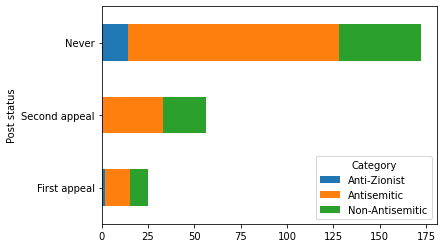

In [18]:
outpot_category_removal_stats.plot(kind='barh', stacked=True,mark_right = True )



אחוזים לפי כל רשת חברתית - כמה תכנים הוסרו מול כמה נשארו


In [19]:
removed = df["Post status"]!="Never"
not_removed = df["Post status"]=="Never"

content_description = df["A short summary of the content- write briefly in your own words"]

print(content_description[removed].count())
print(content_description[not_removed].count())

81
172


In [20]:
outpot_category_removal_stats_by_platform= df.groupby(['Post status', 'Platform'])['Platform'].count().unstack('Platform').fillna(0).astype(int).reindex(index = ['First appeal','Second appeal','Never'])

In [21]:
precentage_chart = outpot_category_removal_stats_by_platform/outpot_category_removal_stats_by_platform[outpot_category_removal_stats_by_platform.columns].sum()*100


In [22]:
precentage_chart.round(1).astype(str) +'%'

Platform,Facebook,Instagram,Other,TikTok,Twitter,YouTube
Post status,,,,,,
First appeal,12.5%,5.1%,100.0%,66.7%,7.1%,42.9%
Second appeal,15.6%,37.5%,0.0%,0.0%,0.0%,0.0%
Never,71.9%,57.4%,0.0%,33.3%,92.9%,57.1%


מילות מפתח בתכנים שהוסרו (בלבד)



In [23]:
#Tokenization process - 
#1. Lowercasing
#2. Translate all words, in any languge - to English
#3. Exclude Stop Words
#4. Identifaing n-grams
#5. Deal with hashtags
#6. Word frequency - think about how to deal with terms which appear multiple times via the text

In [24]:
posts_description = df["A short summary of the content- write briefly in your own words"]

In [25]:
only_removed_content = df["Post status"]!="Never"

In [39]:

only_removed_content = only_removed_content.str.lower()

In [40]:
only_removed_content = only_removed_content.str.replace('[^\w\s]','')

In [41]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
stop = stopwords.words('english')

desc_column_without_sw = only_removed_content.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [30]:
from collections import Counter


In [43]:
 desc_column_without_sw = pd.Series(' '.join(desc_column_without_sw).split()).value_counts()[:50]


In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


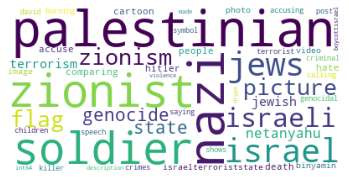

In [44]:
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(str(desc_column_without_sw))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()